## **Dataset**

In [1]:
import os

def load_captions(captions_folder, image_folder):
    captions = {}
    image_files = os.listdir(image_folder)
    for image_file in image_files:
        image_name = image_file.split('.')[0]
        caption_file = os.path.join(captions_folder, image_name + ".txt")
        with open(caption_file, "r") as f:
            caption = f.readlines()[0].strip()
        if image_name not in captions:
                captions[image_name] = caption
    return captions

In [2]:
captions_folder = "./cvpr2016_flowers/captions"
image_folder = "./cvpr2016_flowers/images"

captions = load_captions(captions_folder, image_folder)

In [3]:
len(captions)

8189

In [4]:
for cap in list(captions.items())[:5]:
    print(cap)

('image_03478', 'the petals of the flower have small pink blooms in various shades.')
('image_01003', 'this flower has petals that are yellow with short stamen')
('image_06255', 'the pedicel is split in two halves, with yellow and red petals on the flower.')
('image_01827', 'this flower has multiple layers of white petals surrounding yellow filaments and cone shaped stigma.')
('image_01724', 'the petals are red in color and the stamen is fully visible.')


## **Caption Encoder**

In [5]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)

def encode_captions(captions):
    encoded_captions = {}
    for image_name in captions.keys():
        caption = captions[image_name]
        encoded_captions[image_name] = {
            'embed': torch.tensor(bert_model.encode(caption)),
            'text': caption
        }
    return encoded_captions

/home/hongong/anaconda3/envs/aio2024-homework/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [ ]:
encoded_captions = encode_captions(captions)

In [26]:
encoded_captions["image_03478"]["embed"].shape

torch.Size([768])

## **Preprocessing**

In [7]:
from PIL import Image
from torch.utils.data import Dataset

class FlowerDataset(Dataset):
    def __init__(self, img_dir, captions, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load captions
        self.captions = captions

        self.img_names = list(self.captions.keys())

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name+".jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        encoded_caption = self.captions[img_name]['embed']
        caption = self.captions[img_name]['text']

        return {
            'image': image,
            'embed_caption': encoded_caption,
            'text': caption
        }

In [8]:
import torchvision.transforms as transforms

IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

ds = FlowerDataset(
    img_dir="./cvpr2016_flowers/images",
    captions=encoded_captions,
    transform=transform
)

In [9]:
import matplotlib.pyplot as plt

def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


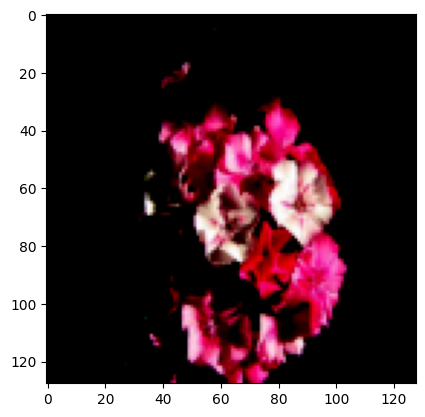

In [10]:
show_grid(next(iter(ds))['image'])

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1024
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
batch_sample = next(iter(dataloader))

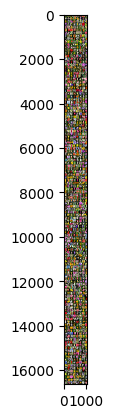

In [13]:
import torchvision

show_grid(torchvision.utils.make_grid(batch_sample['image'], normalize=True))

## **Model**

In [14]:
import torch.nn as nn

class Generator(nn.Module):

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size
        # 768 --> 256
        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.upsamplingBlock = nn.Sequential(
            # 256+100 --> 1024
            nn.ConvTranspose2d(in_channels=noise_size+reduced_dim_size, out_channels=feature_size*8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=feature_size*8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # 1024 --> 512
            nn.ConvTranspose2d(in_channels=feature_size*8, out_channels=feature_size*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=feature_size*4),
            nn.ReLU(inplace=True),
            # 512 --> 256
            nn.ConvTranspose2d(in_channels=feature_size*4, out_channels=feature_size*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=feature_size*2),
            nn.ReLU(inplace=True),
            # 256 --> 128
            nn.ConvTranspose2d(in_channels=feature_size*2, out_channels=feature_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=feature_size),
            nn.ReLU(inplace=True),
            # 128 --> 128
            nn.ConvTranspose2d(in_channels=feature_size, out_channels=num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=feature_size),
            nn.ReLU(inplace=True),
            # 128 --> 3
            nn.ConvTranspose2d(in_channels=num_channels, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, noise, text_embedding):
        encoded_text = self.textEncoder(text_embedding)
        concat_input = torch.cat([noise, encoded_text], dim=1).unsqueeze(2).unsqueeze(2)
        output = self.upsamplingBlock(concat_input)
        return output

In [15]:
generator = Generator(100, 128, 3, 768, 256).to(device)
generator

Generator(
  (textEncoder): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (upsamplingBlock): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), str

In [16]:
class Discriminator(nn.Module):

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size
        
        self.imageEncoder = nn.Sequential(
            # 3 --> 128
            nn.Conv2d(in_channels=num_channels, out_channels=feature_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # 128 --> 128
            nn.Conv2d(in_channels=feature_size, out_channels=feature_size*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # 128 --> 256
            nn.Conv2d(in_channels=feature_size*2, out_channels=feature_size*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=feature_size*4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # 256 --> 512
            nn.Conv2d(in_channels=feature_size*4, out_channels=feature_size*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=feature_size*8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # 512 --> 1024
            nn.Conv2d(in_channels=feature_size*8, out_channels=feature_size*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=feature_size*8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.finalBlock = nn.Sequential(
            nn.Conv2d(in_channels=feature_size*8+reduced_dim_size, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
    
    def forward(self, input_img, text_embedding):
        image_encoded = self.imageEncoder(input_img)
        text_encoded = self.textEncoder(text_embedding)
        replicated_text = text_encoded.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
        concat_layer = torch.cat([image_encoded, replicated_text], dim=1)
        x = self.finalBlock(concat_layer)
        return x.view(-1, 1), image_encoded

In [17]:
discriminator = Discriminator(3, 128, 768, 256).to(device)
discriminator

Discriminator(
  (imageEncoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(neg

## **Training**

In [18]:
bce_loss = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [19]:
plt_o_text_embeddings = ds[0]['embed_caption'].unsqueeze(0)
plt_o_text_embeddings.shape

torch.Size([1, 768])

In [20]:
fixed_noise = torch.randn(size=(1, 100))
fixed_noise.shape

torch.Size([1, 100])

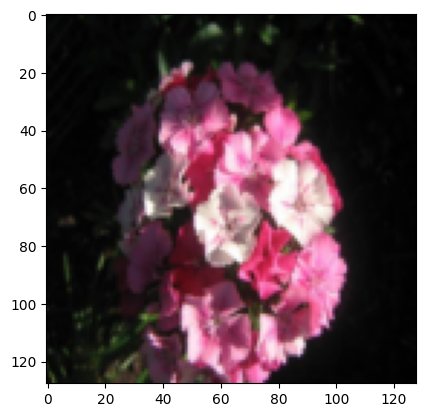

In [21]:
import torchvision

show_grid(torchvision.utils.make_grid(ds[0]['image'], normalize=True))

In [22]:
def plot_output(generator):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise.to(device), plt_o_text_embeddings.to(device))
    generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

In [23]:
import torch.optim as optim

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
import time

epochs = 500

for epoch in range(epochs):

    d_losses, g_losses = [], []

    epoch_time = time.time()

    for batch in dataloader:
        images = batch['image'].to(device)
        embed_captions = batch['embed_caption'].to(device)
        wrong_images = batch["wrong_image"].to(device)

        # labels
        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)
        
        # training the discriminator
        optimizer_D.zero_grad()

        # gen fake image
        noise = torch.randn(images.size(0), 100, device=device)
        fake_images = generator(noise, embed_captions)

        # compute real loss
        outputs, _ = discriminator(images, embed_captions)
        real_loss = bce_loss(outputs, real_labels)

        # compute contrastive loss for wrong image
        outputs, _ = discriminator(wrong_images, embed_captions)
        wrong_loss = bce_loss(outputs, fake_labels)

        # compute fake loss
        outputs, _ = discriminator(fake_images.detach(), embed_captions)
        fake_loss = bce_loss(outputs, fake_labels)

        d_loss = real_loss + fake_loss + wrong_loss

        # update weights
        d_loss.backward()
        optimizer_D.step()
        d_losses.append(d_loss.item())

        # training the generator
        optimizer_G.zero_grad()
        # create noise
        noise = torch.randn(images.size(0), 100, device=device)
        fake_images = generator(noise, embed_captions)

        outputs, fake_features = discriminator(fake_images, embed_captions)
        _, real_features = discriminator(images, embed_captions)
        activation_fake = torch.mean(fake_features, dim=0)
        activation_real = torch.mean(real_features, dim=0)

        # compute loss
        real_loss = bce_loss(outputs, real_labels)
        g_loss = real_loss + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, images)
        g_loss.backward()
        optimizer_G.step()
        g_losses.append(g_loss.item())

    avg_d_loss = sum(d_losses)/len(d_losses)
    avg_g_loss = sum(g_losses)/len(g_losses)

    if (epoch+1) % 10 == 0:
        plot_output(generator)


    print('Epoch [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
        epoch+1, epochs,
        avg_d_loss,
        avg_g_loss,
        time.time() - epoch_time)
    )

## **Prediction**

In [ ]:
generator.eval()

noise = torch.randn(size=(1, 100))
text_embedding = ds[10]['embed_caption'].unsqueeze(0)

with torch.no_grad():
    test_images = generator(noise.to(device), text_embedding.to(device))
grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
show_grid(grid)

In [ ]:
import torch

# Save generator
torch.save(generator.state_dict(), 'generator.pth')

# Save discriminator
torch.save(discriminator.state_dict(), 'discriminator.pth')